In [1]:
import numpy as np
import matplotlib.pyplot as plt
import finesse
from finesse.analysis.actions import RunLocks, Noxaxis
from finesse import ligo
from LLOF3Sqz import make_LLO

finesse.configure(plotting=True)

In [4]:
# LLO = finesse.Model()
# LLO.parse_file("./LIGO_degisn.txt")
# LLO.Mloss.value = 3.75e-05

# removeElements = [
#     "space sqz_p1__OFI_p2 portA=sqz.p1 portB=OFI.p2",
# ]

# unparsed = LLO.unparse()
# for ele in removeElements:
#     unparsed = unparsed.replace(ele, '')

LLO = finesse.Model()
LLO.parse_file("./LIGO_degisn.txt")
# LLO.Mloss.value = 3.75e-05 
LLO.parse("""
###########################################################################
### SQZ path FTblock squeezer
sq sqz db=3 angle=0
#l sqz 0 0

s sqz_M1_OPO sqz.p1 M1_OPO.p1 0

bs M1_OPO R=0 T=1 phi=0 alpha=6

s subM1_OPO M1_OPO.p3 M1_OPO_AR.p1 L=6.35 nr=&nsilica
bs M1_OPO_AR R=0 T=1 phi=0 alpha=6
s lM1_OPO_EDGE M1_OPO_AR.p3 OPO_EDGE.p1 44m
m OPO_EDGE R=0 T=1 phi=0

# edge of OPO block
s lsqz_lens1 OPO_EDGE.p2 sqz_lens1.p1 0

lens sqz_lens1 1

s lsqz_lens1_faraday sqz_lens1.p2 msqz_faraday_a.p1 0

# 20 mm TGG faraday crystal
m msqz_faraday_a R=0 T=1 phi=0
s lsqz_faraday msqz_faraday_a.p2 msqz_faraday_b.p1 L=20m nr=1.95 
m msqz_faraday_b R=0 T=1 phi=0

s lsqz_faraday_lens2 msqz_faraday_b.p2 sqz_lens2.p1 0

lens sqz_lens2 1
s lsqz_lens2_zm1 sqz_lens2.p2 ZM1.p1 0

bs ZM1 T=0 L=0 phi=0 alpha=45
s lzm1_zm2 ZM1.p2 ZM2.p1 1.0

bs ZM2 T=0 L=0 phi=0 alpha=45
s lzm2_OFI ZM2.p2 OFI.p2 0
""")

# print(LLO.unparse())
LLO = make_LLO(LLO)

In [5]:
LLOQNLS = LLO.deepcopy()

LLOQNLS.parse("""
###########################################################################
### pendulum for QRPN
variable Mitmy 39.420 
variable Metmy 39.642
variable Mitmx 39.603
variable Metmx 39.508

pendulum itmx_sus ITMX.mech mass=&Mitmx
pendulum etmx_sus ETMX.mech mass=&Metmx
pendulum itmy_sus ITMY.mech mass=&Mitmy
pendulum etmy_sus ETMY.mech mass=&Metmy

fsig(1)
sgen darmx LX.h
sgen darmy LY.h phase=180

qnoised qnoise OMC_OC.p3.o nsr=True
xaxis(darmx.f, log, 5, 5k, 100, pre_step=run_locks(method='newton', display_progress=false, max_iterations=10000))

""")


# outLLO90 = LLOQNLS.run()
outLLO = LLOQNLS.run()


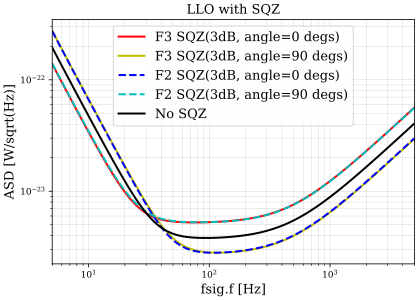

In [6]:
# LLOWithoutOutputOptics = np.load("./LLOWithoutOutputOptics.npy")
# strain_sensitivityF2WithoutSQZ = np.load("../F2 code/strain_sensitivityF2WithoutSQZ.npy")
# QNLSDesignF3 = np.load("../QNLSDesignF3.npy")
strain_sensitivityF2WithSQZ_0degs = np.load("../F2 code/strain_sensitivityF2WithSQZ_0degs.npy") 
strain_sensitivityF2WithSQZ_90degs = np.load("../F2 code/strain_sensitivityF2WithSQZ_90degs.npy") 
strain_sensitivityWithoutSQZ = np.load("../F2 code/strain_sensitivityF2WithoutSQZ.npy")



x = np.logspace(np.log10(5), np.log10(5000), num=101)

fig,ax =plt.subplots(1,1,figsize=(6.5,4.5))

ax.loglog(x, outLLO["qnoise"].real, 'r', lw=2, label='F3 SQZ(3dB, angle=0 degs)')
ax.loglog(x, outLLO90["qnoise"].real, 'y',lw=2, label='F3 SQZ(3dB, angle=90 degs)')
ax.loglog(x, strain_sensitivityF2WithSQZ_0degs, 'b--',lw=2, label='F2 SQZ(3dB, angle=0 degs)')
ax.loglog(x, strain_sensitivityF2WithSQZ_90degs, 'c--',lw=2, label='F2 SQZ(3dB, angle=90 degs)')
ax.loglog(x, strain_sensitivityWithoutSQZ, 'k', lw=2,label="No SQZ")


ax.set_title("LLO with SQZ", fontsize=13)
ax.set_ylabel("ASD [W/sqrt(Hz)]", fontsize=13)
ax.legend(loc = 'best', fontsize=13, ncol=1)

# ax.set_ylabel("The difference", fontsize=13)
ax.set_xlabel("fsig.f [Hz]", fontsize=13);
# fig.savefig('./withSQZ.pdf')